In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs

In [2]:
df = pd.read_csv('mission_launches.csv')
print(df.head())

   Unnamed: 0.1  Unnamed: 0 Organisation  \
0             0           0       SpaceX   
1             1           1         CASC   
2             2           2       SpaceX   
3             3           3    Roscosmos   
4             4           4          ULA   

                                            Location  \
0         LC-39A, Kennedy Space Center, Florida, USA   
1  Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...   
2                      Pad A, Boca Chica, Texas, USA   
3       Site 200/39, Baikonur Cosmodrome, Kazakhstan   
4           SLC-41, Cape Canaveral AFS, Florida, USA   

                         Date                                        Detail  \
0  Fri Aug 07, 2020 05:12 UTC  Falcon 9 Block 5 | Starlink V1 L9 & BlackSky   
1  Thu Aug 06, 2020 04:01 UTC           Long March 2D | Gaofen-9 04 & Q-SAT   
2  Tue Aug 04, 2020 23:57 UTC            Starship Prototype | 150 Meter Hop   
3  Thu Jul 30, 2020 21:25 UTC  Proton-M/Briz-M | Ekspress-80 & Ekspress-103   
4  

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    4324 non-null   int64 
 1   Unnamed: 0      4324 non-null   int64 
 2   Organisation    4324 non-null   object
 3   Location        4324 non-null   object
 4   Date            4324 non-null   object
 5   Detail          4324 non-null   object
 6   Rocket_Status   4324 non-null   object
 7   Price           964 non-null    object
 8   Mission_Status  4324 non-null   object
dtypes: int64(2), object(7)
memory usage: 304.2+ KB


In [4]:
df.isnull().any()

Unnamed: 0.1      False
Unnamed: 0        False
Organisation      False
Location          False
Date              False
Detail            False
Rocket_Status     False
Price              True
Mission_Status    False
dtype: bool

In [5]:
# Fill NaN with '0' and convert to numeric type
df['Price'] = pd.to_numeric(df['Price'], errors = 'coerce')
df['Price'] = df['Price'].fillna('0').replace('NaN','0')
df['Price'] = df['Price'].astype(float)

In [6]:
# Compute the mean, rounding to 2 decimal places
mean_r = round(df['Price'].mean(), 2)
df['Price'] = df['Price'].replace(0,mean_r)

In [7]:
df['Price'].describe()

count    4324.000000
mean       50.723735
std        79.098645
min         5.300000
25%        28.490000
50%        28.490000
75%        28.490000
max       450.000000
Name: Price, dtype: float64

In [8]:
#Change the datetime to standard date system
df['Date'] = pd.to_datetime(df['Date'], utc=True, errors='coerce')

#Add Year column with the year it was lauched
df['Year']=df['Date'].dt.year
df['Year'] = df['Year'].fillna(0).astype(int)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Unnamed: 0.1    4324 non-null   int64              
 1   Unnamed: 0      4324 non-null   int64              
 2   Organisation    4324 non-null   object             
 3   Location        4324 non-null   object             
 4   Date            4198 non-null   datetime64[ns, UTC]
 5   Detail          4324 non-null   object             
 6   Rocket_Status   4324 non-null   object             
 7   Price           4324 non-null   float64            
 8   Mission_Status  4324 non-null   object             
 9   Year            4324 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(5)
memory usage: 337.9+ KB


,Unnamed: 0.1,Unnamed: 0,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status,Year
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.00,Success,2020
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success,2020
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00+00:00,Starship Prototype | 150 Meter Hop,StatusActive,28.49,Success,2020
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.00,Success,2020
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,145.00,Success,2020


In [9]:
#Create a column Country to simplify the information
df['Country'] = df['Location'].apply( lambda x: x.split(',')[-1].strip())

In [10]:
#Drop unnamed column 'Unnamed: 0.1', 'Unnamed: 0'
df = df.drop(columns=["Unnamed: 0.1"])
df = df.drop(columns=["Unnamed: 0"])

In [11]:
# Split the 'detail' column into a list by '|'
split_col = df['Detail'].str.split('|')

# Strip whitespace and assign first element to 'rocket_type', rest joined into 'payloads'
df['rocket_type'] = split_col.str[0].str.strip()
df['payloads'] = split_col.apply(lambda x: ' | '.join([s.strip() for s in x[1:]]) if len(x) > 1 else '')

print(df)

     Organisation                                           Location  \
0          SpaceX         LC-39A, Kennedy Space Center, Florida, USA   
1            CASC  Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...   
2          SpaceX                      Pad A, Boca Chica, Texas, USA   
3       Roscosmos       Site 200/39, Baikonur Cosmodrome, Kazakhstan   
4             ULA           SLC-41, Cape Canaveral AFS, Florida, USA   
...           ...                                                ...   
4319      US Navy           LC-18A, Cape Canaveral AFS, Florida, USA   
4320         AMBA           LC-26A, Cape Canaveral AFS, Florida, USA   
4321      US Navy           LC-18A, Cape Canaveral AFS, Florida, USA   
4322    RVSN USSR          Site 1/5, Baikonur Cosmodrome, Kazakhstan   
4323    RVSN USSR          Site 1/5, Baikonur Cosmodrome, Kazakhstan   

                          Date                                        Detail  \
0    2020-08-07 05:12:00+00:00  Falcon 9 Block 5 | Star

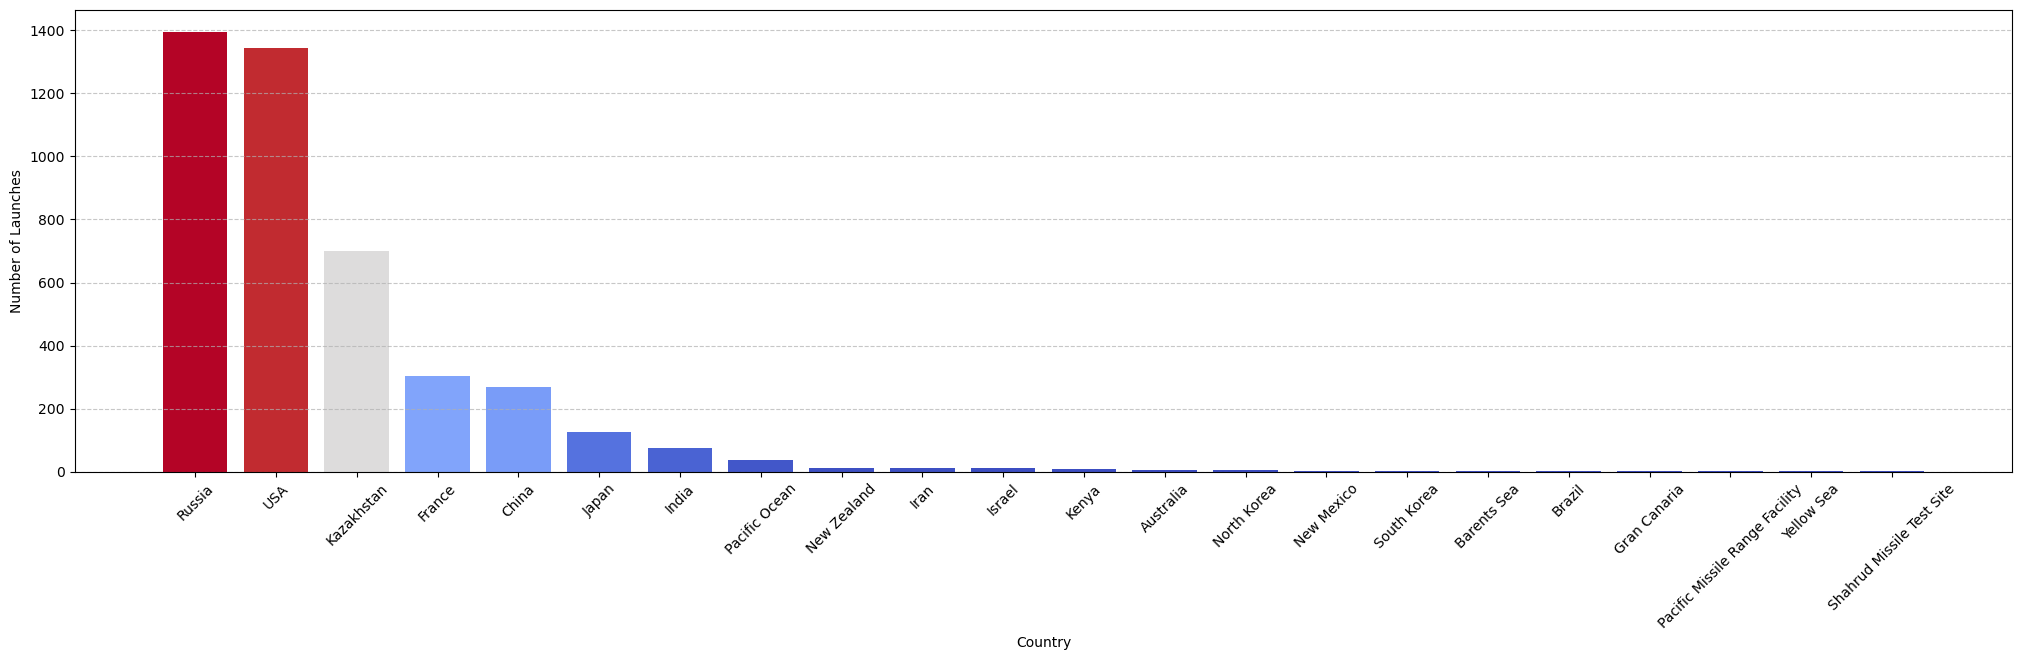

In [12]:
#Count the number of launches per country and plot it
launch_counts = df['Country'].value_counts()
norm = (launch_counts - launch_counts.min()) / (launch_counts.max() - launch_counts.min())

# Colormap to map values to colors
colors = cm.coolwarm(norm)
plt.figure(figsize=(25, 6))
bars = plt.bar(launch_counts.index, launch_counts.values, color=colors)
plt.xticks(rotation=45)
plt.xlabel("Country")
plt.ylabel("Number of Launches")
plt.grid(axis='y', linestyle='--', alpha=0.7)

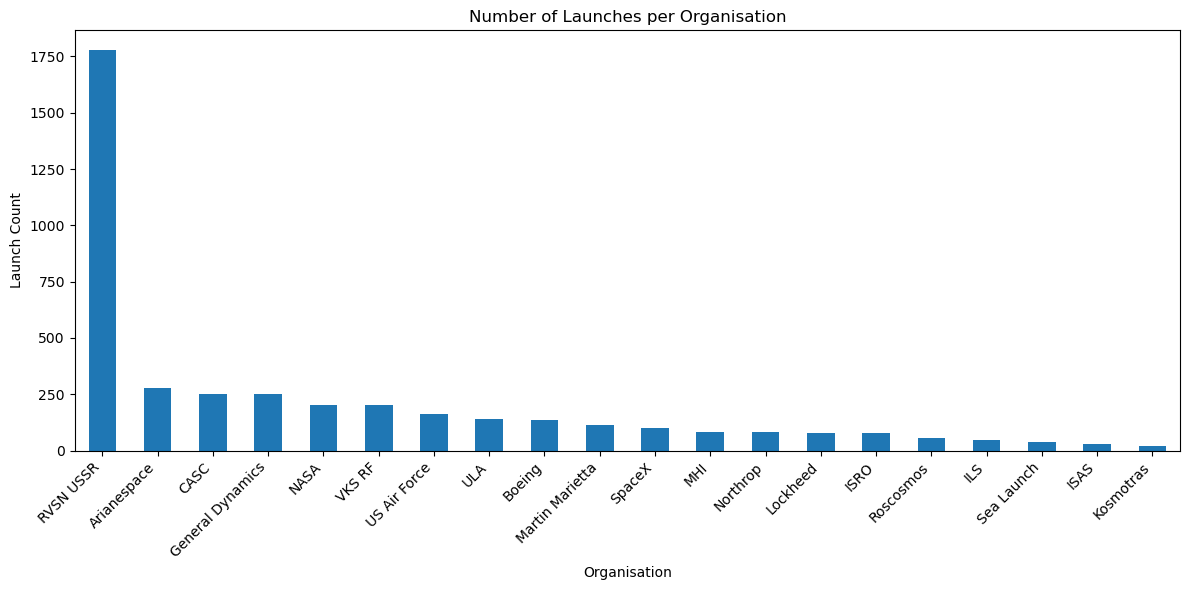

In [13]:
location_counts = df['Organisation'].value_counts()

plt.figure(figsize=(12, 6))
location_counts.head(20).plot(kind='bar')
plt.title("Number of Launches per Organisation")
plt.xlabel("Organisation")
plt.ylabel("Launch Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

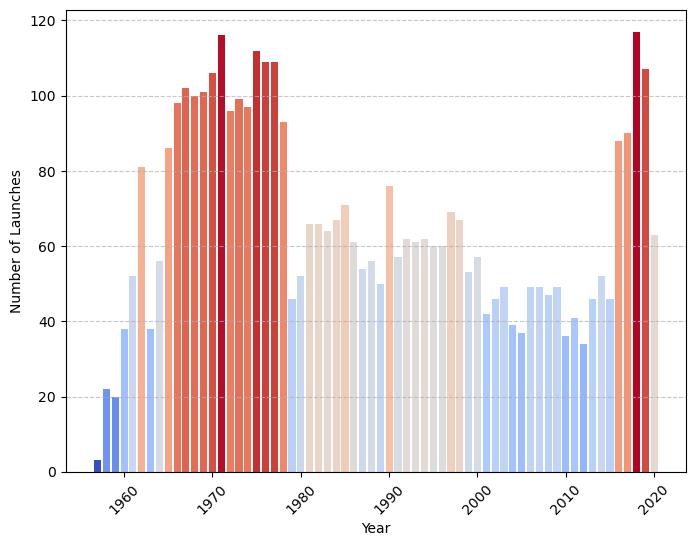

In [14]:
# Count the number of launches per year and plot it
lauches_cold_war =  df[df['Year']>=1900]
launch_counts = lauches_cold_war['Year'].value_counts()
norm = (launch_counts - launch_counts.min()) / (launch_counts.max() - launch_counts.min())

# Colormap to map values to colors
colors = cm.coolwarm(norm)
plt.figure(figsize=(8, 6))
bars = plt.bar(launch_counts.index, launch_counts.values, color=colors)
plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Number of Launches")
plt.grid(axis='y', linestyle='--', alpha=0.7)

Text(0, 0.5, 'Average Price')

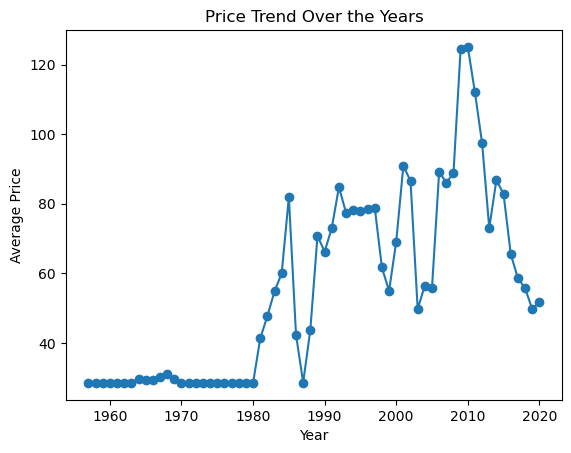

In [15]:
# Plot the average price spent for each year
lauches_cold_war =  df[df['Year']>=1900]
average_price = lauches_cold_war.groupby('Year')['Price'].mean().reset_index()


plt.plot(average_price['Year'], average_price['Price'], marker='o')
plt.title('Price Trend Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Price')

In [16]:
lauches_cold_war =  df[df['Year']>=1900]

# Group by both 'Year' and 'Mission_Status', then count the occurrences
status_counts = lauches_cold_war.groupby(['Year', 'Mission_Status']).size().unstack(fill_value=0)

status_counts = status_counts[['Failure', 'Partial Failure', 'Prelaunch Failure', 'Success']]
print(status_counts)

Mission_Status  Failure  Partial Failure  Prelaunch Failure  Success
Year                                                                
1957                  1                0                  0        2
1958                 14                2                  0        6
1959                  9                3                  0        8
1960                 19                0                  0       19
1961                 17                3                  0       32
...                 ...              ...                ...      ...
2016                  2                1                  1       84
2017                  5                2                  0       83
2018                  2                2                  0      113
2019                  5                2                  0      100
2020                  6                0                  0       57

[64 rows x 4 columns]


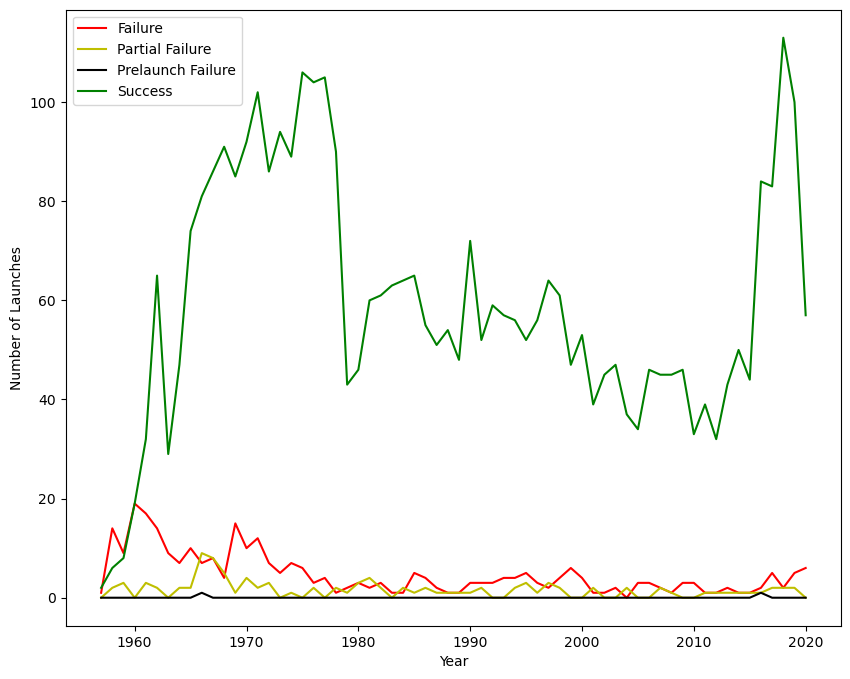

In [17]:
#Plot line chart with years and their status
plt.figure(figsize = (10,8))

plt.plot(status_counts.index, status_counts['Failure'], color='r', label='Failure')
plt.plot(status_counts.index, status_counts['Partial Failure'], color='y', label='Partial Failure')
plt.plot(status_counts.index, status_counts['Prelaunch Failure'], color='black', label='Prelaunch Failure')
plt.plot(status_counts.index, status_counts['Success'], color='g', label='Success')

plt.xlabel("Year")
plt.ylabel("Number of Launches")
plt.legend()

In [18]:
df.describe()

,Price,Year
count,4324.000000,4324.000000
mean,50.723735,1929.541859
std,79.098645,334.799288
min,5.300000,0.000000
25%,28.490000,1971.000000
50%,28.490000,1984.000000
75%,28.490000,2002.000000
max,450.000000,2020.000000


In [19]:
df

,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status,Year,Country,rocket_type,payloads
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.00,Success,2020,USA,Falcon 9 Block 5,Starlink V1 L9 & BlackSky
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success,2020,China,Long March 2D,Gaofen-9 04 & Q-SAT
2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00+00:00,Starship Prototype | 150 Meter Hop,StatusActive,28.49,Success,2020,USA,Starship Prototype,150 Meter Hop
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.00,Success,2020,Kazakhstan,Proton-M/Briz-M,Ekspress-80 & Ekspress-103
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,145.00,Success,2020,USA,Atlas V 541,Perseverance
...,...,...,...,...,...,...,...,...,...,...,...
4319,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1958-02-05 07:33:00+00:00,Vanguard | Vanguard TV3BU,StatusRetired,28.49,Failure,1958,USA,Vanguard,Vanguard TV3BU
4320,AMBA,"LC-26A, Cape Canaveral AFS, Florida, USA",1958-02-01 03:48:00+00:00,Juno I | Explorer 1,StatusRetired,28.49,Success,1958,USA,Juno I,Explorer 1
4321,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1957-12-06 16:44:00+00:00,Vanguard | Vanguard TV3,StatusRetired,28.49,Failure,1957,USA,Vanguard,Vanguard TV3
4322,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan",1957-11-03 02:30:00+00:00,Sputnik 8K71PS | Sputnik-2,StatusRetired,28.49,Success,1957,Kazakhstan,Sputnik 8K71PS,Sputnik-2


## Correlation Heatmap

In [20]:
df = pd.get_dummies(df, columns=['Mission_Status'])

In [21]:
df['Mission_Status'] = df['Mission_Status_Success'].astype(int)

                                     Price      Year  Mission_Status_Failure  \
Price                             1.000000  0.060674               -0.066771   
Year                              0.060674  1.000000               -0.155817   
Mission_Status_Failure           -0.066771 -0.155817                1.000000   
Mission_Status_Partial Failure   -0.028641  0.024348               -0.045334   
Mission_Status_Prelaunch Failure -0.005331 -0.084902               -0.008875   
Mission_Status_Success            0.073908  0.134178               -0.861124   
Mission_Status                    0.073908  0.134178               -0.861124   

                                  Mission_Status_Partial Failure  \
Price                                                  -0.028641   
Year                                                    0.024348   
Mission_Status_Failure                                 -0.045334   
Mission_Status_Partial Failure                          1.000000   
Mission_Status_Prel

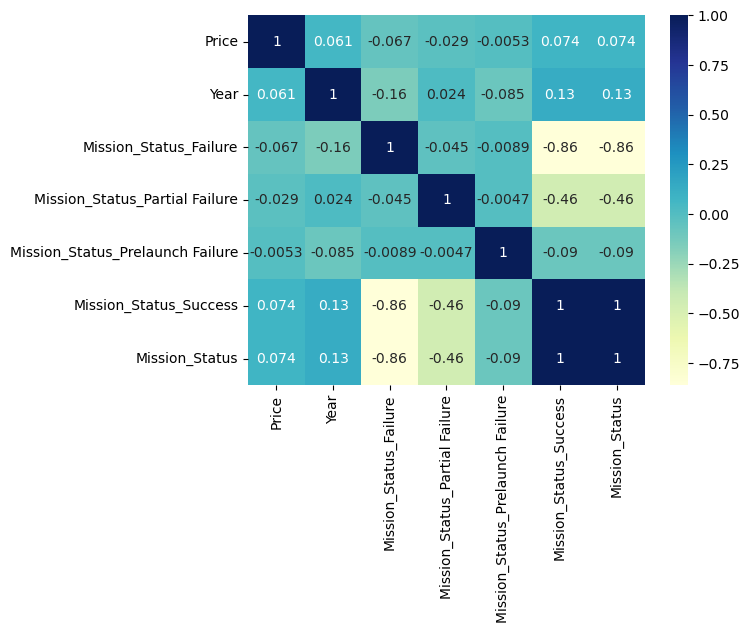

<Figure size 1200x1000 with 0 Axes>

In [22]:
# Compute correlation matrix
co_mtx = df.corr(numeric_only=True)

# Print correlation matrix
print(co_mtx)

# Plot correlation heatmap
sns.heatmap(co_mtx, cmap="YlGnBu", annot=True)

# Display heatmap
plt.figure(figsize=(12, 10))
plt.show()

In [23]:
#Use Year, country, price, organization, rocket type as X variables
#Use Mission_Status as predictor variables 
#Logistic Regression, Random Forest, KNN, XGBoost
#Heatmap for correlated variables 
#Date, Country, Year

In [24]:
df

,Organisation,Location,Date,Detail,Rocket_Status,Price,Year,Country,rocket_type,payloads,Mission_Status_Failure,Mission_Status_Partial Failure,Mission_Status_Prelaunch Failure,Mission_Status_Success,Mission_Status
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.00,2020,USA,Falcon 9 Block 5,Starlink V1 L9 & BlackSky,False,False,False,True,1
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,2020,China,Long March 2D,Gaofen-9 04 & Q-SAT,False,False,False,True,1
2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00+00:00,Starship Prototype | 150 Meter Hop,StatusActive,28.49,2020,USA,Starship Prototype,150 Meter Hop,False,False,False,True,1
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.00,2020,Kazakhstan,Proton-M/Briz-M,Ekspress-80 & Ekspress-103,False,False,False,True,1
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,145.00,2020,USA,Atlas V 541,Perseverance,False,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1958-02-05 07:33:00+00:00,Vanguard | Vanguard TV3BU,StatusRetired,28.49,1958,USA,Vanguard,Vanguard TV3BU,True,False,False,False,0
4320,AMBA,"LC-26A, Cape Canaveral AFS, Florida, USA",1958-02-01 03:48:00+00:00,Juno I | Explorer 1,StatusRetired,28.49,1958,USA,Juno I,Explorer 1,False,False,False,True,1
4321,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1957-12-06 16:44:00+00:00,Vanguard | Vanguard TV3,StatusRetired,28.49,1957,USA,Vanguard,Vanguard TV3,True,False,False,False,0
4322,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan",1957-11-03 02:30:00+00:00,Sputnik 8K71PS | Sputnik-2,StatusRetired,28.49,1957,Kazakhstan,Sputnik 8K71PS,Sputnik-2,False,False,False,True,1


## Random Forest Classifier 


In [25]:
#Picking Feature data and Target Variable
X = df[['Year', 'Country', 'Price', 'Organisation', 'payloads']]
y = df['Mission_Status']

#One Hot Encoding
X = pd.get_dummies(X, drop_first=True)

#Splitting Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Use Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

#Training Classifier
model.fit(X_train_scaled, y_train)

#Model Prediction
y_pred = model.predict(X_test_scaled)

#Evaluate performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9110

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.16      0.27        87
           1       0.91      0.99      0.95       778

    accuracy                           0.91       865
   macro avg       0.85      0.58      0.61       865
weighted avg       0.90      0.91      0.88       865


Confusion Matrix:
 [[ 14  73]
 [  4 774]]


## KNN Nearest Neighbor Classifier

In [54]:
# 1. Generate a synthetic dataset
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1.5, random_state=42)

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Initialize the KNeighborsClassifier
# You can experiment with different values for 'n_neighbors' (k)
knn = KNeighborsClassifier(n_neighbors=5)

# 4. Train the model
knn.fit(X_train, y_train)

# 5. Make predictions on the test set
y_pred = knn.predict(X_test)

# 6. Evaluate the model's accuracy
#accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of KNN with k=5: {accuracy:.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

## XGBoost Forest Classifier 

In [60]:
df

,Organisation,Location,Date,Detail,Rocket_Status,Price,Year,Country,rocket_type,payloads,Mission_Status_Failure,Mission_Status_Partial Failure,Mission_Status_Prelaunch Failure,Mission_Status_Success,Mission_Status
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.00,2020,USA,Falcon 9 Block 5,Starlink V1 L9 & BlackSky,False,False,False,True,1
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,2020,China,Long March 2D,Gaofen-9 04 & Q-SAT,False,False,False,True,1
2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00+00:00,Starship Prototype | 150 Meter Hop,StatusActive,28.49,2020,USA,Starship Prototype,150 Meter Hop,False,False,False,True,1
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.00,2020,Kazakhstan,Proton-M/Briz-M,Ekspress-80 & Ekspress-103,False,False,False,True,1
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,145.00,2020,USA,Atlas V 541,Perseverance,False,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1958-02-05 07:33:00+00:00,Vanguard | Vanguard TV3BU,StatusRetired,28.49,1958,USA,Vanguard,Vanguard TV3BU,True,False,False,False,0
4320,AMBA,"LC-26A, Cape Canaveral AFS, Florida, USA",1958-02-01 03:48:00+00:00,Juno I | Explorer 1,StatusRetired,28.49,1958,USA,Juno I,Explorer 1,False,False,False,True,1
4321,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1957-12-06 16:44:00+00:00,Vanguard | Vanguard TV3,StatusRetired,28.49,1957,USA,Vanguard,Vanguard TV3,True,False,False,False,0
4322,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan",1957-11-03 02:30:00+00:00,Sputnik 8K71PS | Sputnik-2,StatusRetired,28.49,1957,Kazakhstan,Sputnik 8K71PS,Sputnik-2,False,False,False,True,1


In [61]:
df['Mission_Status'].value_counts()

Mission_Status
1    3879
0     445
Name: count, dtype: int64